## Oppgave 2 a\)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit

In [35]:
#Initial grid
binding_sites = np.zeros(501)

center = len(binding_sites)//2
half_span = 50 #101 particles = 2*50 +1

binding_sites[center - half_span : center + half_span + 1] = 1

#Potential
@njit
def V1(x : int, k : float) -> float:
    """Constant potential

    Args:
        x: Position
        k: Intercept

    Returns:
        Potential value V1(x) = -k
    """
    return k

@njit
def V2(x : int, k : float) -> float:
    """Linear potential

    Args:
        x: Position
        k: Slope
        
    Returns:
        Potential value V2(x) = - k*x
    """
    return -k*x

#Probability
@njit
def p(x0 : int, V , beta : float, k : float) -> tuple[float, float]:
    """Probabliity of stepping to left or right from given position

    Args:
        x0: Current position
        V: Potential function V(x) that returns scalar potential value
        beta: Physical parameter 1/(k_B T)
        k: Potential physical parameter
        
    Returns:
        p_minus: Probablity of step to x0-1
        p_plus: Probablity of step to x0+1
    """
    
    p_minus = 1.0/(1.0 + np.exp(-beta*(V(x0 + 1, k) - V(x0 - 1, k))) + np.exp(-beta*(V(x0, k) - V(x0 - 1, k))))
    p_plus = 1.0/(1.0 + np.exp(-beta*(V(x0 - 1, k) - V(x0 + 1, k))) + np.exp(-beta*(V(x0, k) - V(x0 + 1, k))))
    
    return np.array([p_minus, p_plus])

In [42]:
#Walk simulation
@njit
def random_walk(initial_grid : np.ndarray, V, n_steps: int, beta : float, k : float) -> np.ndarray:
    """Simulates random walk without exclusion in given potential

    Args:
        initial_grid: Initial distribution of particles on binding sites
        V: Potential function V(x) that returns scalar potential value
        n_steps: Number of steps 
        beta: Physical parameter
        k: Potential physical paramater

    Returns: 
        grid: Updated grid with new particle positions 
    """
    grid = initial_grid.copy()
    n_sites = len(grid)
    
    for _ in range(n_steps):
        grid_new = np.zeros(n_sites)
        
        for i in range(n_sites):
            
            n_particles = int(grid[i])
            
            if n_particles == 0:
                continue
            
            for _ in range(n_particles):
                p_minus, p_plus = p(i, V, beta, k)
                r = np.random.uniform(0.0, 1.0)
                
                if r < p_minus:
                    grid_new[i - 1] += 1
                elif r > 1 - p_plus:
                    grid_new[i + 1] += 1
                else:
                    grid_new[i] += 1
                    
        grid = grid_new
        
    return grid

#Several simulations and step
def sim_walk(initial_grid: np.ndarray, V, n_steps: int, n_sim: int, beta: float, k: float) -> tuple[np.ndarray, np.ndarray]:
    """Run n_sim random-walk simulations, plot mean final particle distribution, and return the x-grid and averaged distribution

    Args:
        initial_grid: Initial distribution of particles
        V: Potential function V(x) that returns svalar potential value 
        n_steps:  Number of steps
        n_sim: Number of simulations
        beta: Physical parameter
        k: Potential physical paramater

    Returns:
        x: Site coordinates centered around zero
        mean_grid: Mean final particle distribution across all runs
    """
    n_sites = len(initial_grid)
    
    grids = np.zeros((n_sim, n_sites))
    
    for i in range(n_sim):
        grid = random_walk(initial_grid, V, n_steps, beta, k)
        grids[i] = grid

    mean_grid = np.mean(grids, axis = 0)
    x = np.arange(n_sites) - n_sites//2
        
    fig, ax = plt.subplots(figsize = (8, 4))
    
    ax.plot(x, mean_grid)
    ax.set_xlabel("x")
    ax.set_ylabel("Average particle count")
    ax.set_title(f"Average dist of particles after {n_steps} steps and {n_sim} runs")
    ax.grid()
    plt.show()
    
    return x, mean_grid

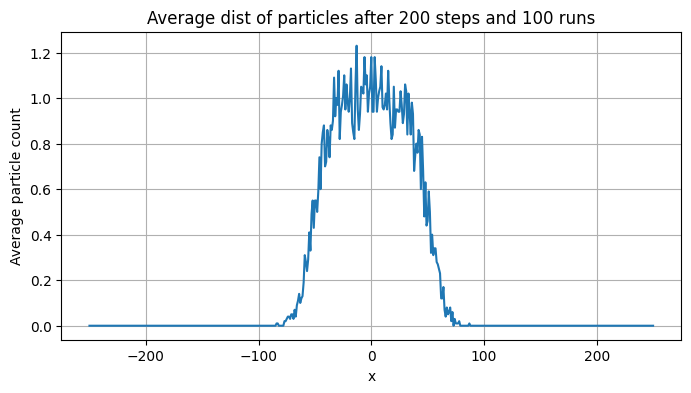

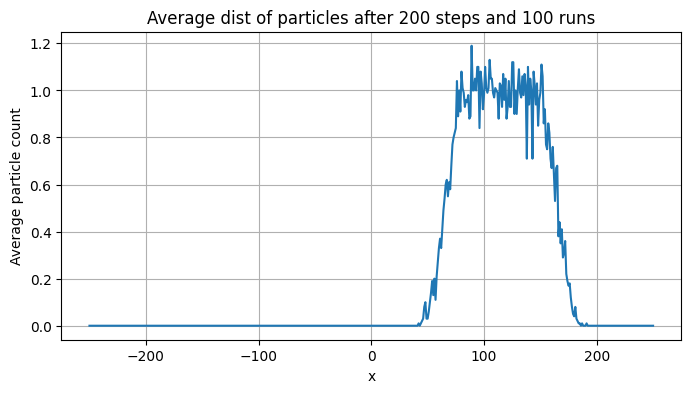

In [46]:
kb = 1.38 * 10**-23
Temp = 298
beta2 = 1.0

x, mean_grid = sim_walk(binding_sites, V1, n_steps = 200, n_sim = 100, beta = beta2, k = 1.0)
x, mean_grid = sim_walk(binding_sites, V2, n_steps = 200, n_sim = 100, beta = beta2, k = 1.0)

## Oppgave 2 b)

In [49]:
@njit
def random_walk_exclusion(initial_grid: np.ndarray, V, n_steps: int, beta: float, k: float) -> np.ndarray:
    """Simulates random walk without exclusion in given potential

    Args:
        initial_grid: Initial distribution of particles
        V: Potential function V(x) that returns svalar potential value 
        n_steps:  Number of steps
        n_sim: Number of simulations
        beta: Physical parameter
        k: Potential physical paramater
        
    Returns:
        Grid with particles particle positions (0/1)
    """
  
    occupancy = initial_grid.astype(np.bool_) 
    positions = np.where(occupancy)[0].copy() 
    
    for _ in range(n_steps):
        np.random.shuffle(positions)
        
        for idx in range(len(positions)):
            i = positions[idx]
            
            p_minus, p_plus = p(i, V, beta, k)
            r = np.random.uniform(0.0, 1.0)
                
            if r < p_minus:
                new_i = i-1
            elif r > 1 - p_plus:
                new_i = i + 1
            else:
                new_i = i
        
            if occupancy[new_i]:
                continue
            
            occupancy[i] = False
            occupancy[new_i] = True
            positions[idx] = new_i
            
    return occupancy.astype(np.int64)

def sim_walk_exclusion(initial_grid: np.ndarray, V, n_steps: int, n_sim: int, beta: float, k: float) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Run n_sim simulations with and without exclusion, plot both mean final distributions, and return x plus both averages

    Args:
        initial_grid: Initial distribution of particles
        V: Potential function V(x) that returns svalar potential value 
        n_steps:  Number of steps
        n_sim: Number of simulations
        beta: Physical parameter
        k: Potential physical paramater

    Returns:
        x: Site coordinates centered around zero
        mean_grid: Mean final distribution for non_exclusion
        mean_grid_exclusion: Mean final dsitribution for exclusion
    """
    n_sites = len(initial_grid)
    
    grids = np.zeros((n_sim, n_sites))
    grids_exclusion = np.zeros((n_sim, n_sites))
    
    for i in range(n_sim):
        grid = random_walk(initial_grid, V, n_steps, beta, k)
        grid_exclusion = random_walk_exclusion(initial_grid, V, n_steps, beta, k)
        grids[i] = grid
        grids_exclusion[i] = grid_exclusion

    mean_grid = np.mean(grids, axis = 0)
    mean_grid_exclusion = np.mean(grids_exclusion, axis = 0)
    x = np.arange(n_sites) - n_sites//2
        
    fig, ax = plt.subplots(figsize = (8, 4))
    
    ax.plot(x, mean_grid, label = "Non-exclusion")
    ax.plot(x, mean_grid_exclusion, label = "Exclusion")
    ax.set_xlabel("x")
    ax.set_ylabel("Average particle count")
    ax.set_title(f"Average dist of particles after {n_steps} steps and {n_sim} runs")
    ax.grid()
    plt.legend()
    plt.show()
    
    return x, mean_grid, mean_grid_exclusion


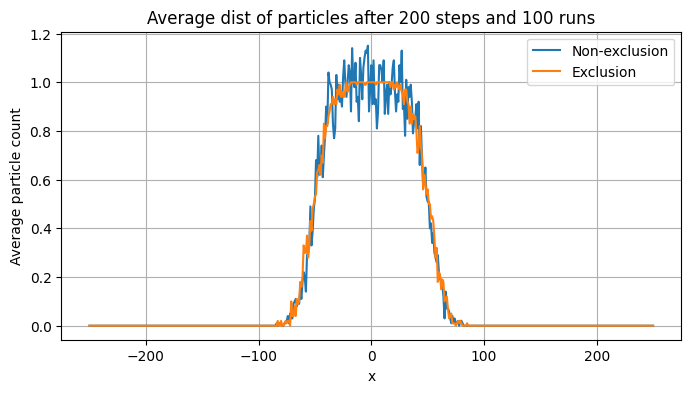

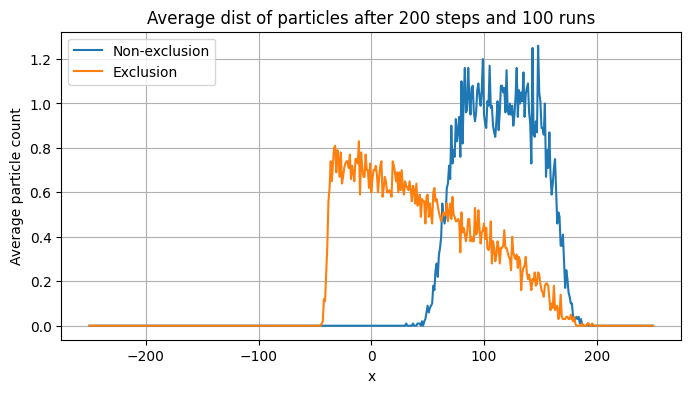

In [50]:
x, mean_grid, mean_grid_exclusion = sim_walk_exclusion(binding_sites, V1, n_steps = 200, n_sim = 100, beta = beta2, k = 1.0)
x, mean_grid, mean_grid_exclusion = sim_walk_exclusion(binding_sites, V2, n_steps = 200, n_sim = 100, beta = beta2, k = 1.0)

## Oppgave 2 c)

Improve probablity function for this one, since beta*k = 1000 is very high. Take inspiration from elias prob function perhaps

## Oppgave 3 a)

In [ ]:
beta3 = 1/(kb*Temp)

@njit
def walk_dir(p_minus: float, p_plus: float) -> int:
    """Choose a random walk direction based on left/right move probabilities

    Args:
        p_minus: Probability of a move to the left (minus)
        p_plus: Probability of a move to the right (plus)

    Returns:
        step: Integer step value (-1, 0, or 1)
    """
    rand_val = np.random.ranf()
    if rand_val <= p_minus:
        return -1
    elif rand_val >= (1 - p_plus):
        return 1
    else:
        return 0


@njit
def v31(x: int, n_x: int, alpha: float, k: float, beta : float) -> float:
    """Calculate the periodic potential V31 at position x

    Args:
        x: Position on x axis
        n_x: Length of intervall for periodic potential V31
        alpha: Position of potential switch within n_x, pos = n_x*alpha
        k: Konstant for potential strength

    Returns:
        v: Potential value at position x for V31
    """
    x_per = x % n_x
    if x_per < alpha * n_x:
        return k * x_per / (alpha * n_x * beta)
    else:
        x_per = x_per - n_x
        return -k * x_per / ((1 - alpha) * n_x * beta)


@njit
def v32(x: int, n_x: int, alpha: float, k: float, beta : float) -> float:
    """Calculate the periodic potential V32 at position x

    Args:
        x: Position on x axis
        n_x: Length of intervall for periodic potential V31
        alpha: Position of potential switch within n_x, pos = n_x*alpha
        k: Konstant for potential strength

    Returns:
        v: Potential value at position x for V32
    """
    return 1 / beta


@njit
def probs_3(beta: float, x: int, n_x: int, alpha: float, k: float, t: int, t_p: int):
    """Calculate the probabilities of all possible moves with the partition function

    Args:
        beta: Constant equal to 1/Kb*T
        x: Position on x axis
        n_x: Length of intervall for periodic potential V31
        alpha: Position of potential switch within n_x, pos = n_x*alpha
        k: Konstant for potential strength
        t: Timestep witin [0,2*t_p]
        t_p: Time period between potential switches V31/V32

    Returns:
        p_minus, p_plus: Probabilites for a move to the left (minus) and right (plus)
    """

    if -0.01/beta<(periodic_pot(t, t_p, x, n_x, alpha, k, beta) - periodic_pot(t, t_p, x + 1, n_x, alpha, k, beta))<0.01/beta:
        return 1/3,1/3
    b = -beta * (periodic_pot(t, t_p, x, n_x, alpha, k, beta) - periodic_pot(t, t_p, x + 1, n_x, alpha, k, beta))
    a = -beta * (periodic_pot(t, t_p, x - 1, n_x, alpha, k, beta) - periodic_pot(t, t_p, x + 1, n_x, alpha, k, beta))
    c = -beta * (periodic_pot(t, t_p, x + 1, n_x, alpha, k, beta) - periodic_pot(t, t_p, x - 1, n_x, alpha, k, beta))
    d = -beta * (periodic_pot(t, t_p, x, n_x, alpha, k, beta) - periodic_pot(t, t_p, x - 1, n_x, alpha, k, beta))

    if a > 50:
        a = 50
    elif a < -50:
        a = -50
    if b > 50:
        b = 50
    elif b < -50:
        b = -50
    if c > 50:
        c = 50
    elif c < -50:
        c = -50
    if d > 50:
        d = 50
    elif d < -50:
        d = -50

    p_plus = 1.0 / (1.0 + np.exp(a) + np.exp(b))
    p_minus = 1.0 / (1.0 + np.exp(c) + np.exp(d))

    return p_minus, p_plus


@njit
def periodic_pot(t: int, t_p: int, x: int, n_x: int, alpha: float, k: float, beta: float) -> float:
    """Select the periodic potential based on the current time step

    Args:
        t: Timestep witin [0,2*t_p]
        t_p: Time period between potential switches V31/V32
        x: Position on x axis
        n_x: Length of intervall for periodic potential V31
        alpha: Position of potential switch within n_x, pos = n_x*alpha
        k: Konstant for potential strength

    Returns:
        v: Potential value at position x for the active potential (V31 or V32)
    """
    if t % (2 * t_p) < t_p:
        return v32(x, n_x, alpha, k, beta)
    else:
        return v31(x, n_x, alpha, k, beta)


@njit
def walk_step(n_x: int, alpha: float, k: float, beta: float, n_p: int, t: int, t_p: int, x: np.ndarray, interval: int):
    """Perform one timestep of the random walk for all particles

    Args:
        n_x: Length of intervall for periodic potential V31
        alpha: Position of potential switch within n_x, pos = n_x*alpha
        k: Konstant for potential strength
        n_p: Number of particles
        t: Timestep witin [0,2*t_p]
        t_p: Time period between potential switches V31/V32
        x: Array of particle positions
        interval: Maximum position value (wrap-around boundary)

    Returns:
        x: Updated array of particle positions after one timestep
        flow: Normalized net flow (n_plus - n_minus) / n_p for this timestep
    """
    np.random.shuffle(x)
    n_plus = 0
    n_minus = 0
    for j in range(len(x)):
        p_minus, p_plus = probs_3(beta, x[j], n_x, alpha, k, t, t_p)
        step = walk_dir(p_minus, p_plus)

        if step == 1:
            n_plus += 1
            if x[j] == interval:
                x[j] = 0
            else:
                x[j] += step
        elif step == -1:
            n_minus += 1
            if x[j] == 0:
                x[j] = interval
            else:
                x[j] += step
    flow = (n_plus - n_minus) / n_p
    return x, flow


def sim_3(t_p: int, n_x: int, alpha: float, k: float, beta : float, n_p: int, cycles: int, interval: int):
    """Simulate the random walk with a switching periodic potential over multiple cycles

    Args:
        t_p: Time period between potential switches V31/V32
        n_x: Length of intervall for periodic potential V31
        alpha: Position of potential switch within n_x, pos = n_x*alpha
        k: Konstant for potential strength
        n_p: Number of particles
        cycles: Number of full cycles to simulate
        interval: Maximum position value (wrap-around boundary)

    Returns:
        x: Final array of particle positions after all cycles
        avg_flow: Array of average flow per cycle
    """
    x = np.array([[i for _ in range((n_p // interval))] for i in range(n_p // (n_p // interval))]).flatten()
    avg_flow = np.zeros(cycles)

    for cycle in range(cycles):
        flow_t = np.zeros(2 * t_p)
        for t in range(2 * t_p):
            x, flow = walk_step(n_x, alpha, k, beta, n_p, t, t_p, x, interval)
            flow_t[t] = flow
        avg_flow[cycle] = flow_t.sum() / (2 * t_p)

    return x, avg_flow


x_10, avg_flow_08 = sim_3(500, 100, 0.8, 1000, beta3, 1200, 10, 200)
x_10, avg_flow_01 = sim_3(500, 100, 0.1, 1000, beta3, 1200, 10, 200)

In [18]:
print(avg_flow_08)
print(avg_flow_01)


[-0.03008167 -0.01315917 -0.01197417 -0.0130725  -0.014055   -0.01156417
 -0.01280167 -0.01383667 -0.01055    -0.01205083]
[0.03891583 0.0273475  0.02948667 0.02722    0.02788833 0.02479167
 0.02638667 0.02645917 0.026035   0.029735  ]


### i)
Vi får ikke-null partikkelstrømmer fordi potensial 1 har en positiv derivert for 80% av tall linjen, mot de 20%ene som er dekt av den negative deriverte. Selvom vi gjennom en hel syklus i posisjoner for potensial 1 går fra minimum til maksimum tilbake til minimum, vil vi fortsatt ha flere partikler som beveger seg til venstre for hver iterasjon da sum av skritt ikke er direkte proposjonal med magnitude av gradienten til potensialet ganget med område den dekker.

Fysiskt kan dette forklares med at vi har et område delt inn i mange seksjoner på en meter, der vi kan forskyve inndelingene litt for å få en potensialfunskjon med en dal i hver inndeling der vi starter på -0.2 meter og går til 0.8 osv gjennom område. Her vil potensialet være like maksimalt for -0.2 og 0.8 meter, og gå lineært ned mot minmium ved 0 meter. For å oppnå lavest potensiell energi vil alle partiklene bevege seg til posisjonen ved 0 meter, her kan vi se at hvis partiklene orginalt er jevnt fordelt vil flere partikler gå mot venstre enn høyre, som resulterer i en negativ gjennomsnittlig partikkelflyt ($J_{avg}$).


### ii)
Vi ser at den første målingen av $J_{avg}$ er betydelig større enn alle de andre målingene som er relatvit like. Dette an forklares ved at partiklene orginalt er jevt fordelt for å så bevege seg slik at de i praksis alle er ved minimalt potensial under potensial 1, deretter byttes potensialet til potensial 2 som er konstant, og fører til tilfeldig bevegelse, på grunn av at denne tilfeldige bevegelsen skjer i en veldig begrenset tidsperiode, og at partiklene i utgangspunktet alle er veldig nær posisjon 0, forventer vi at de er betydelig nærmere posisjon 0 enn når de var jevnt fordelte ved tidspunktet der vi bytter tilbake til potensial 1. Dette gjør at vi får mindre bevegelse og derfor en lavere $J_{avg}$.


### iii)
Her ser vi at $J_{avg}$ er mot høyre isteden for venstre (positiv isteden for negativ) som vi forventer da potensial 1 nå har mye større del med negativ derivert enn positiv derivert. 



Oppgave 3 b)

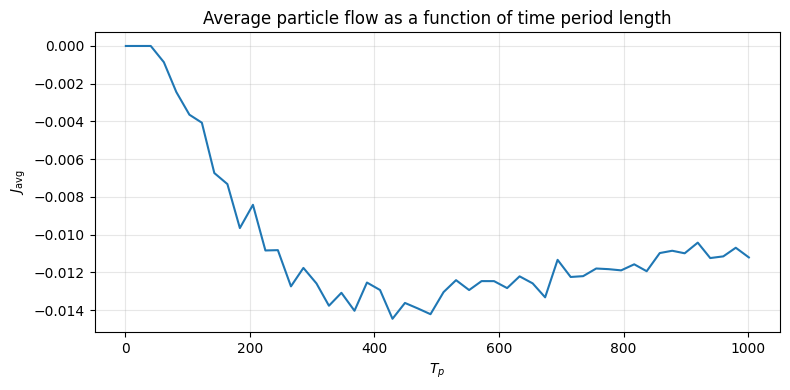

In [19]:
def sim_3b(t_p: int, n_x: int, alpha: float, k: float, beta: float,
           n_p: int, cycles: int, pos1: int, pos2: int, interval: int):

    x = np.array([[pos1 for _ in range(n_p // 2)],
                  [pos2 for _ in range(n_p // 2)]]).flatten()

    flow_t = np.zeros(2 * t_p)

    for t in range(2 * t_p):
        x, flow = walk_step(n_x, alpha, k, beta, n_p, t, t_p, x, interval)
        flow_t[t] = flow

    avg_flow = flow_t.sum() / (2 * t_p)
    return x, avg_flow

def plotter(title: str, x_label: str, y_label: str, x: np.ndarray, y: np.ndarray, rows: int, cols: int):
    fig, ax = plt.subplots(rows,cols,figsize = (8, 4))
    ax.plot(x,y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()


t_p_array = np.int64(np.linspace(1, 1001, 50))

flow_array_3b = np.zeros(len(t_p_array), dtype=np.float64)

for i in range(len(t_p_array)):
    x, avg_flow_3b = sim_3b(t_p_array[i], 100, 0.8, 1000, beta3, 40 * 100, 1, 100, 200, 300)
    flow_array_3b[i] = avg_flow_3b

plotter("Average particle flow as a function of time period length", r"$T_p$", r"$J_{\mathrm{avg}}$", t_p_array, flow_array_3b, 1, 1)





### i)
Vi observer at magnituden $J_{avg}$ starter rundt null, for å så gå opp til et maksimum ved $T_p \in [350, 550]$, magnituden av flyten minker etter dette. En tolkning av den initielle økningen i magnitude er at partiklene trenger noe tid for å spre seg utover mens potensial 2 er aktivt for at vi skal se noe utslag i $J_{avg}$. Dette kan forklares ved at partiklene vil gå veldig lite vekk fra minimum i potensial 1 ved et lavt antall tidssteg som fører til at veien tilbake til minimum er like lang uavhengig av hvilken ve de gikk da asymmetrien i potensialet i prakisis "ikke oppdages" av partiklene, dette gjør da at $J_{avg}$ blir null.

For å forklare hvorfor magnituden igjen går ned ved en tilstrekkelig høy verdi for $T_p$, kan vi se på formelen for å regne ut $J_{avg}$. Vi har tenkt oss at denne er i noen grad porposjonal med hvor langt partiklene er unna minimumet i potensial 1, dette vil i vårt tilfelle makismeres når partiklene er uniformt fordelt, når vi ser bort fra ekstremt usannsynlige tilfeller. videre vet vi at $J_{avg}$ er lineært omvendtproposjonalt med T_p, mens den gjennomsnittlige avstanden fra en partikkel til minimum i potensial 1 er avvtakende proposjonal $T_p$. Dette gjør at vi vil får en kamp mellom det positive bidraget til magnitudena v flyten fra $T_p$ som har en negativ derivert, og det negative bidraget fra $T_p$ som har en konstant derivert, gitt at det positive bidraget starter større enn det negative må vi da finne et eller annet punkt $T_{p_{maks}} > T_{p_0}$ der magnituden av $J_{avg}$ maksimeres.

## Oppgave 3 c)

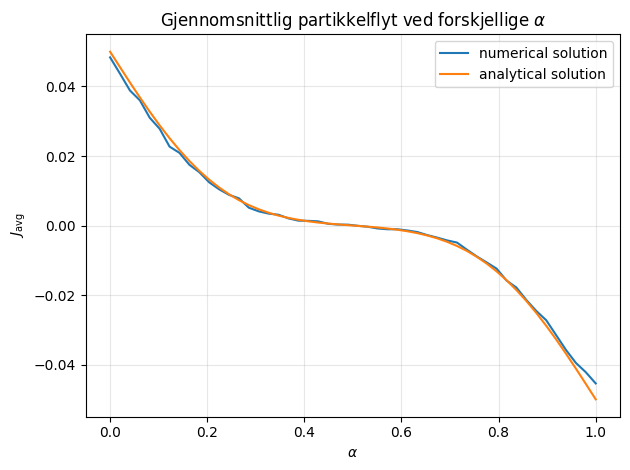

In [20]:
import math as math

def analytic_flow(n_x: int, t_p: int, alpha: float):
    return n_x/(4*t_p) * (
        math.erfc(alpha*n_x/2*np.sqrt(3/t_p))
        - math.erfc((1-alpha)*n_x/2*np.sqrt(3/t_p))
    )

alpha_array = np.linspace(0, 1, 50)

flow_array_3c = np.zeros(len(alpha_array), dtype=np.float64)
analytic_flow_array_3c = np.zeros(len(alpha_array), dtype=np.float64)

for i in range(len(alpha_array)):
    x, avg_flow = sim_3b(500, 100, alpha_array[i], 1000, beta3, 40*100, 1, 100, 200, 300)
    flow_array_3c[i] = avg_flow
    analytic_flow_array_3c[i] = analytic_flow(100, 500, alpha_array[i])

plt.plot(alpha_array, flow_array_3c, label="numerical solution")
plt.plot(alpha_array, analytic_flow_array_3c, label="analytical solution")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$J_{\mathrm{avg}}$")
plt.title(r"Gjennomsnittlig partikkelflyt ved forskjellige $\alpha$")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

    

Den nummeriske løsningen vår er veldig lik den analytiske løsningen som tyder på at oppgaven er løst rett. Vi ser en korrelasjon mellom $|\alpha-0.5|$ og magnituden av $J_{avg}$

## Oppgave 4a\)

In [21]:
#Params
Tp = 20
beta4 = 1000/(kb*298)

In [22]:
@njit
def build_initial(width: int, partition: int, Nx: int, Ns: int, Np: int = -1) -> np.ndarray:
    """Build an initial grid with particles spread out around the center
    
    Args:
        width: Total width of particles
        partition: How much of grid should be particle-covered
        Nx: Sites per sawtooth period
        Ns: Number of sawtooth periods
        Np: Number of particles to place. Default Np = -1 computes from partition. 
        
    Returns:
        initial_grid : 1D array (0/1) of length Ns*Nx where 1 symbolizes occupied site
    """
    binding_sites = np.zeros(Ns*Nx)
    center = len(binding_sites)//2
    initial_grid = binding_sites.copy()
    
    N_possible = len(binding_sites)//width
    if Np == -1:
        Np = N_possible//partition
    if Np <= 0:
        return initial_grid
    elif Np > N_possible:
        Np = N_possible
        
    initial_grid[center] = 1
    half = (Np - 1)//2
    
    for n in range(1, half + 1):
        initial_grid[(center - n*width)%len(binding_sites)] = 1
        initial_grid[(center + n*width)%len(binding_sites)] = 1
    
    if Np%2 == 0:
        initial_grid[(center + (half + 1) * width) % len(binding_sites)] = 1
    
    return initial_grid

   
    
#Random walk
@njit
def random_walk_exclusion_sawtooth(initial_grid: np.ndarray, 
                                   Tp: int, 
                                   width: int, 
                                   Nx: int, Ns: int, Nc: int,
                                   alpha: float, k: float, beta: float,
                                   h: int, store_positions:bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulates random walk with exclusion principle in rachet potential

    Args:
        initial_grid: Initial distribution of particles (0/1)
        Tp : Half-period of potential-switching
        width: Total width of particles
        Nx: Sites per sawtooth period
        Ns: Number of sawtooth periods
        Nc: Number of full cycles
        alpha: Potential physical parameter
        k: Potential physical parameter
        beta: Physical parameter
        h: Time-step size
        store_positions: Defaults to True. If True, store particle positions for each time step

    Returns:
        occupancy: Array(True/False) describing particle locations in final grid
        cycle_avg_J: Cycle-averaged current 
        positions_arr: Stores positions (T, Np) for each time step if enabled, else (1,1) zero-array
    """
    T = 2*Nc*Tp
    occupancy = initial_grid.astype(np.bool_)
    positions = np.where(occupancy)[0].copy()
    Np = len(positions)
    if store_positions:
        positions_arr = np.zeros((T, Np), dtype=np.int64)
    else:
        positions_arr = np.zeros((1, 1), dtype=np.int64)
        
    J_arr = np.zeros(T)
    order = np.arange(Np)
    
    for t in range(0, T, h):
        nplus = 0
        nminus = 0
        np.random.shuffle(order)
        
        for n in range(Np):
            idx = order[n]
            i = positions[idx]
            
            p_minus, p_plus = probs_3(beta, i, Nx, alpha, k , t, Tp)
            
            step = walk_dir(p_minus, p_plus)
            new_i = (i + step)%(Ns*Nx)

            check_left = np.arange(new_i - width + 1, new_i +1)%len(occupancy)
            check_right = np.arange(new_i , new_i + width)%len(occupancy)
            
            if new_i == (i + 1) % (Ns*Nx) and occupancy[check_right].any():
                continue
            elif new_i == (i - 1) % (Ns*Nx) and occupancy[check_left].any():
                continue
            
            occupancy[i] = False
            occupancy[new_i] = True
            positions[idx] = new_i
            
            if new_i == (i + 1) % (Ns*Nx): 
                nplus += 1
            elif new_i == (i - 1) % (Ns*Nx): 
                nminus += 1
            
        J_arr[t] = (nplus - nminus)/Np
        if store_positions:
            positions_arr[t] = positions
            
    n_cycles = len(J_arr)//(2*Tp)       
    J_reshaped = J_arr.reshape(n_cycles, 2*Tp)
    cycle_avg_J = np.zeros(n_cycles)
    
    for c in range(n_cycles):
        cycle_avg_J[c] = J_reshaped[c].mean()
        
    return occupancy.astype(np.int64), cycle_avg_J, positions_arr


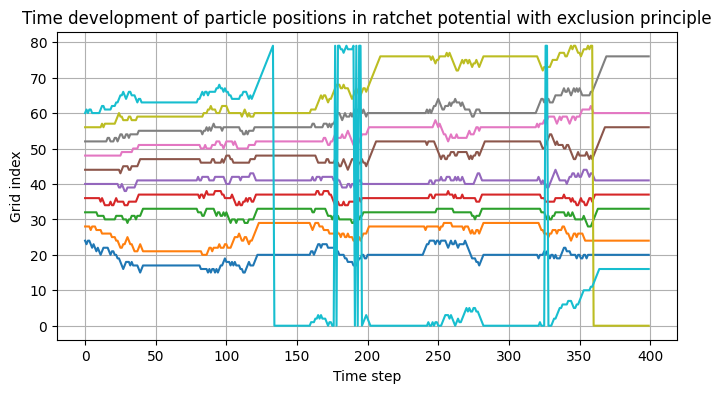

In [23]:
def plot_walk_exclusion_sawtooth(Tp: int, 
                                 width: int, 
                                 Nx: int, Ns: int, Nc: int, 
                                 alpha: float, beta: float, k: float,
                                 Np: int = -1, 
                                 h: int = 1) -> None:
    """Plots the time evolution of particle positions in random walk in ratchet potential with exclusion principle

    Args:
        Tp : Half-period of potential-switching
        width: Total width of particles
        Nx: Sites per sawtooth period
        Ns: Number of sawtooth periods
        Nc: Number of full cycles
        alpha: Potential physical parameter
        k: Potential physical parameter
        beta: Physical parameter
        Np: Number of particles. Defaults to -1.
        h: Time-step size. Defaults to 1. 

    Returns:
        None
    """
    initial_grid = build_initial(width, 2, Nx, Ns, Np)
    grid, cycle_av_J, positions_arr = random_walk_exclusion_sawtooth(initial_grid, Tp, width, Nx, Ns, Nc, alpha, k, beta, h)
    
    fig, ax = plt.subplots(figsize = (8, 4))
    
    time = np.arange(len(positions_arr))
    for p in range(positions_arr.shape[1]):
        ax.plot(time, positions_arr[:, p])
    
    ax.set_title("Time development of particle positions in ratchet potential with exclusion principle")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Grid index")  
    ax.grid()  

    plt.show()

    return None

plot_walk_exclusion_sawtooth(Tp=40, width=4, Nx=20, Ns=4, Nc=5, alpha=0.2, beta = beta4, k=1000)

Vi ser at partiklene aldri krysser hverandre, og alltid har en avstand større en b imellom hverandre, som stemmer med antagelsene våres. De store hoppene fra indeks 80 til 0 og vice versa for for eksempel den lyseblå grafen, kommer fra at vi har loopet koordinatsystemet. Det er lite variasjon i de miderste partiklene, siden disse vil ha en større tendens til å kollidere med andre partikler, som vi ser er reflektert i at det ofte er lange områder uten bevegelse (flat graf). Det ser ut til at det er en drift mot høyre (pluss) som vi diskuterte i oppgave 3, så dette stemmer også godt. 

## Oppgave 4b\) 

In [ ]:
def plot_current_particle_exclusion_sawtooth(Tp: int, 
                                             width: int, 
                                             Ns: int, Nx: int, Nc: int, N_min: int, N_max: int, 
                                             alpha: float, k: float, beta: float, 
                                             h: float = 1) -> None:
    """Plot cycle-averaged current J_avg as function of particle density rho for the exclusion sawtooth model

    Args:
        Tp : Half-period of potential-switching
        width: Total width of particles
        Ns: Number of sawtooth periods
        Nx: Sites per sawtooth period
        Nc: Number of full cycles
        N_min: Minimum amount of particles. Should be at least 1 to avoid division-by-zero error
        N_max: Maximum amount of particles
        alpha: Potential physical parameter
        k: Potential physical parameter
        beta: Physical parameter
        h: Time-step size. Defaults to 1.

    Returns:
        None: Displays the plot
    """
    Np_arr = np.arange(N_min, N_max + 1)
    cycle_avg_J_arr = np.zeros(len(Np_arr))
    rho_arr = np.zeros(len(Np_arr))
    
    for i, Np in enumerate(Np_arr):
        rho = width * Np /(Ns * Nx)
        initial_grid = build_initial(width, 2, Nx, Ns, Np)
        
        grid, cycle_avg_J, positions_arr = random_walk_exclusion_sawtooth(initial_grid, Tp, width, Nx, Ns, Nc, alpha, k, beta, h, store_positions = False)
        
        cycle_avg_J_arr[i] = cycle_avg_J.mean()
        rho_arr[i] = rho
        
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.plot(rho_arr, cycle_avg_J_arr)
    ax.set_title("Average current as function of particle density")
    ax.set_xlabel(r"$\rho$")
    ax.set_ylabel(r"$J_{avg}$")
    ax.grid()

    plt.show()
    
    return None

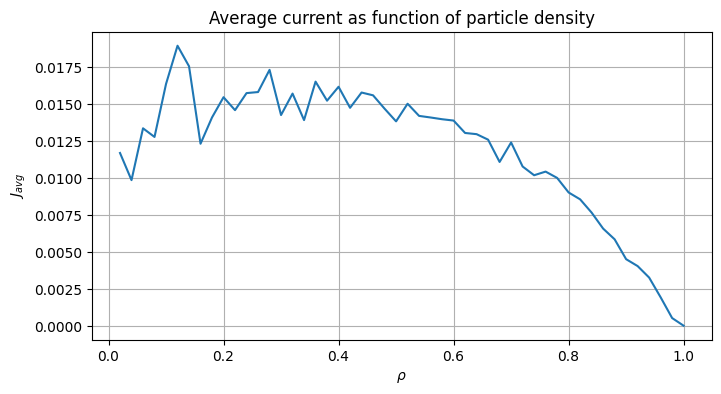

In [25]:
plot_current_particle_exclusion_sawtooth(Tp = 300, width = 20, Ns = 10, Nx = 100, Nc = 100, N_min = 1, N_max = 50, alpha = 0.2, k = 1000, beta = beta4)

Når partikkeltettheten øker forventer vi flere kollisjoner og mindre drift av partikler, derfor burde $J_{avg}$ minke for høyere $\rho$, som også er reflektert i grafen.

## Oppgave 4c\)

In [ ]:
def plot_current_period_exclusion_sawtooth(width: int, 
                                            Tp_min : int,
                                            Tp_max: int,
                                            Ns: int, Nx: int, 
                                            alpha: float, k: float, beta: float, 
                                            h: float = 1) -> None:
    """Plot cycle-averaged current J_avg as function of half period T_p for the exclusion sawtooth model

    Args:
        width: Total width of particles
        Tp_min: Minimum half period
        Tp_max (int): Maximum half period
        Ns (int): Number of sawtooth periods
        Nx (int): Sites per sawtooth period
        alpha (float): Potential physical parameter
        k (float): Potential physical parameter
        beta (float): Physical parameter
        h (float, optional): Time-step size. Defaults to 1.

    Returns:
        None: Displays the plot
    """
    Tp_arr = np.arange(Tp_min, Tp_max + 1, 10)
    cycle_avg_J_arr = np.zeros(len(Tp_arr))
    
    for i, Tp in enumerate(Tp_arr):
        Nc = 30000//Tp
        initial_grid = build_initial(width, 2, Nx, Ns)
        
        grid, cycle_avg_J, positions_arr = random_walk_exclusion_sawtooth(initial_grid, Tp, width, Nx, Ns, Nc, alpha, k, beta, h, store_positions = False)
        
        cycle_avg_J_arr[i] = cycle_avg_J.mean()
    
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.plot(Tp_arr, cycle_avg_J_arr)
    ax.set_title(r"Average current as function of half-period with $T_p N_c = 30 000$")
    ax.set_xlabel(r"$T_p$")
    ax.set_ylabel(r"$J_{avg}$")
    ax.grid()
    
    return None

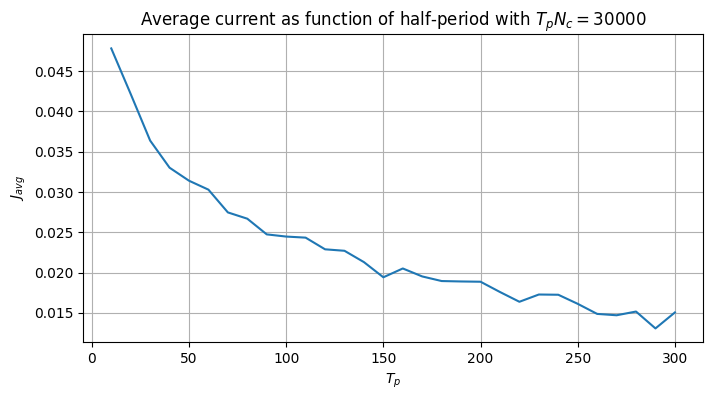

In [27]:
plot_current_period_exclusion_sawtooth(width = 20, Tp_min = 10, Tp_max = 300, Ns = 10, Nx = 100, alpha = 0.2, k = 1000, beta = beta4)

Høyere $T_p$ gir lengre faser av hvert potensial. For høyere $T_p$ varer da fasene lengre, og systemet rekker i større grad å nærme seg likevekt i hver fase, som gir mindre netto drift per syklus. Dette reflekteres også i plottet. Siden $T_p N_c$ holdes konstant vil også større $T_p$ bety færre sykluser, som øker usikkerheten. Uten å kunne fastlå dette med sikkerhet, ser det ut som at volatiliteten også øker med $T_p$, som er å forvente. 